Accのセンサデータ以外のものも加えてみる

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [11]:
fold = "../train_raw_npy/"
acc_xyz = np.load(f"{fold}acc_xyz.npy")
gyr_xyz = np.load(f"{fold}gyr_xyz.npy")
mag_xyz = np.load(f"{fold}mag_xyz.npy")
label = np.load(f"{fold}sampled_label.npy")
xyz = np.concatenate([acc_xyz, gyr_xyz, mag_xyz], axis=1)
print(acc_xyz.shape)
print(gyr_xyz.shape)
print(mag_xyz.shape)
print(xyz.shape)
print(label.shape)

(196072, 3, 500)
(196072, 3, 500)
(196072, 3, 500)
(196072, 9, 500)
(196072,)


In [12]:
from sklearn.preprocessing import StandardScaler

# データを2Dに変換して標準化
scaler = StandardScaler()
xyz_reshaped = xyz.reshape(-1, xyz.shape[-1])  # (196072*3, 500)
scaled_xyz = scaler.fit_transform(xyz_reshaped)  # 標準化
scaled_xyz = scaled_xyz.reshape(xyz.shape)  # 元の形に戻す

print(scaled_xyz.shape)  # (196072, 3, 500)


(196072, 9, 500)


In [4]:
#おしり3万データを使う  
xyz = scaled_xyz[-40000:-10000,:]
label = label[-40000:-10000]
print(xyz.shape)
print(label.shape)

(30000, 9, 500)
(30000,)


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# ランダムサンプリング
train_xyz, test_xyz, train_label, test_label = train_test_split(scaled_xyz, label, test_size=0.2, shuffle=True,random_state=40)

# 結果の確認
print(f"Train data shape: {train_xyz.shape}")
print(f"Test data shape: {test_xyz.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())
# train_randomの生成
train_xyz_random = train_xyz
train_label_random = train_label

Train data shape: (156857, 9, 500)
Test data shape: (39215, 9, 500)
Train label shape: (156857,)
Test label shape: (39215,)
5.0    25279
7.0    25112
6.0    22596
2.0    19596
1.0    19521
8.0    19199
4.0    18797
3.0     6757
Name: count, dtype: int64
5.0    6454
7.0    6141
6.0    5730
2.0    4948
1.0    4935
4.0    4676
8.0    4635
3.0    1696
Name: count, dtype: int64


In [6]:
class ConvBNReLU(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,

            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            dropout=0.0 # ドロップアウト率を新規追加
    ):
        super(ConvBNReLU, self).__init__()

        self.main = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(True)
        )
        if dropout > 0:
            self.main.append(nn.Dropout(dropout))

        # He初期化
        nn.init.kaiming_normal_(self.main[0].weight, mode='fan_out', nonlinearity='relu')
        if self.main[0].bias is not None:
            nn.init.constant_(self.main[0].bias, 0)
    
    def forward(self,x):
        return self.main(x)
    

    
class CNN(nn.Module):
    def __init__(self, output_size=8, in_channels=3, num_filters_init=8, dropout=0.0):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            ConvBNReLU(in_channels, num_filters_init, 3,1,1), # 500 -> 500
            ConvBNReLU(num_filters_init, num_filters_init*2, 8,2,3,dropout=dropout ), # 500->250
            ConvBNReLU(num_filters_init*2, num_filters_init*3, 6,2,2,dropout=dropout), # 250 -> 125 (248)
            ConvBNReLU(num_filters_init*3, num_filters_init*3,7,2,2, dropout=dropout), # 125 -> 62
            ConvBNReLU(num_filters_init*3, num_filters_init*4,6,2,1 , dropout=dropout), # 62 -> 30
            ConvBNReLU(num_filters_init*4, num_filters_init*4, 4, 2, 1, dropout=dropout), # 30 -> 15
            ConvBNReLU(num_filters_init*4, num_filters_init*4, 3, 2, 1, dropout=dropout), # 15->8
            ConvBNReLU(num_filters_init*4, num_filters_init*4, 8,1,0, dropout=dropout), # 8 -> 1 
            #nn.Conv1d(num_filters_init*128, output_size, 1,1,0) #代わりに下の全結合層を導入
        )
        # 全結合層
        self.fc = nn.Sequential(
            nn.Linear(num_filters_init*4, num_filters_init*2),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(num_filters_init*2, num_filters_init),
            nn.ReLU(True),
            nn.Dropout(dropout),
            
            nn.Linear(num_filters_init, output_size)
        )

        nn.init.kaiming_normal_(self.fc[0].weight, mode="fan_out", nonlinearity="relu")
        nn.init.kaiming_normal_(self.fc[3].weight, mode="fan_out", nonlinearity="relu")
        #nn.init.kaiming_normal_(self.fc[6].weight, mode="fan_out", nonlinearity="relu")
        
        

        # 最後のConv1dにもHe初期化を適用
        #nn.init.kaiming_normal_(self.cnn[-1].weight, mode='fan_out', nonlinearity='relu')
        #if self.cnn[-1].bias is not None:
        #    nn.init.constant_(self.cnn[-1].bias, 0)
        
    
    def forward(self, x):
        x = self.cnn(x).view(x.size(0), -1)
        return self.fc(x)
        #return x

In [7]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    
    #データセットをバッチサイズごとに分割
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = X[idxs_batch].astype('f4')

        X_batch = torch.from_numpy(X_batch)
        if y is None:
            yield X_batch
        else:
            y_batch = y[idxs_batch]
            y_batch = torch.from_numpy(y_batch-1)
            yield X_batch, y_batch


def forward_by_batches(cnn, X):
    Y = []
    cnn.eval()
    with torch.no_grad():
        for x in create_dataloader(X, batch_size=1024, shuffle=False):
            x = x.to(device)
            Y.append(cnn(x))
    cnn.train()

    Y = torch.cat(Y) # Yをテンソルに変換
    return Y


def evaluate_model(cnn, X, Y):
    Y_pred = forward_by_batches(cnn, X)
    loss = F.cross_entropy(Y_pred, torch.from_numpy(Y-1.0).type(torch.int64).to(device)).item() # クロスエントロピー損失の計算 仕方なく0~7クラス分類とする

    Y_pred = F.softmax(Y_pred, dim=1) 
    Y_pred = torch.argmax(Y_pred, dim=1)  # 最も高い確率のY_predのラベルを予測ラベルとしてY_predに入れられる。
    Y_pred = Y_pred + 1  # 予測ラベルに1を加えて1~8の範囲に変換する
    Y_pred = Y_pred.cpu().numpy()  # テンソルでGPUにのっているものをcpuに移動して、それをさらにnumpy配列に変換している。
    kappa = metrics.cohen_kappa_score(Y, Y_pred) # 1~8クラス分類

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}

In [14]:
import torch.optim.lr_scheduler as lr_scheduler
num_filters_init = 60 # 16:    32:0.85(test limit) 25が最強だった（データ数3万では） 全体では60が最高評価
in_channels = 9 
output_size = len(np.unique(train_label_random))  #　これは分類するラベルの数。最終層の特徴量の数
num_epoch = 5  # num of epochs (full loops though the training set)
lr = 5e-4  # learning rate 3e-4だった


cnn = CNN(
    output_size=output_size,
    in_channels=in_channels,
    num_filters_init=num_filters_init,
    dropout=0.3 # filter=32, dropout0.3
).to(device)
print(cnn) # ここではcnnのネットワーク構造の定義をして、そのネットワークの構造をprintしている。

loss_fn = nn.CrossEntropyLoss() # クロスエントロピー損失を使用してモデルの出力と実際のラベルとの差を計算するためのインスタンス定義
optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=1e-3) # オプティマイザーを使用し、設定された学習率lrでモデルのパラメータを最適化する。Adamはよく使われるやつでパフォーマンスが高いらしい　
# optim.Adam()ではcnnのパラメータへの直接参照をすることができるnum_filters
# 学習率スケジューラの定義
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

CNN(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(9, 60, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(60, 120, kernel_size=(8,), stride=(2,), padding=(3,))
        (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (2): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(120, 180, kernel_size=(6,), stride=(2,), padding=(2,))
        (1): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (3): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(180, 180, kernel_size=(7,), stride=(2,),

In [15]:
kappa_history_test = []
loss_history_test = []
loss_history_train = []
losses = []
num_epoch = 300
batch_size = 600  # size of the mini-batch　バッチサイズを64にしている 64が今のところ最高評価
count = 0
for i in tqdm(range(num_epoch)): # 同じデータセットでnum_epoch回cnnを学習させている。
    if i!=0:
        if loss.item() < 0.3 and count==0:
            batch_size = 2048
            count += 1
            print(f"batch_size:{batch_size}, count:{count}")
        if count!=0:
            count +=1
        if count == 25:
            batch_size = batch_size*2
            #count+=1
            print(f"batch_size:{batch_size}, count:{count}")
        if count == 50:
            print("break!")
            break
        

    dataloader = create_dataloader(train_xyz_random, train_label_random, int(batch_size), shuffle=True)
    

    for x, target in dataloader:
        x, target = x.to(device), target.type(torch.int64).to(device) # ここでdeviceにデータを移行
        cnn.zero_grad()
        output = cnn(x) # バッチxをネットワークに通し、予測値outputを取得
        loss = loss_fn(output, target) # 予測値と実際のラベルtargetとの間の損失を計算する。ネットワークの出力outputと正解targetとの間の差異を計算しその結果としてスカラー値lossを生成する。
        loss.backward() # 計算されたlossに従ってネットワークのすべてのパラメータに対する勾配が計算される。
        optimizer.step() # オプティマイザが保存している勾配情報を使用してモデルのパラメータを更新　直接cnnに紐づいているのでcnnのパラメータを直接更新している

        # Logging -- track train loss
        losses.append(loss.item()) # ログを残している。lossというのはパラメータのgradientでパラメータを更新する方向や大きさを決めている。

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch
    # --------------------------------------------------------
    #scheduler.step()  # エポックの終わりに学習率を調整

    # Logging -- average train loss in this epoch
    loss_history_train.append(utils.ewm(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(cnn, test_xyz, test_label)
    loss_history_test.append(results['loss'])
    kappa_history_test.append(results['kappa'])
     # エポックごとの損失や精度を記録
    print(f"Epoch {i+1}/{num_epoch}, Loss: {loss.item()}, test Loss:{results['loss']}")

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300, Loss: 1.3504002094268799, test Loss:1.3706735372543335
Epoch 2/300, Loss: 1.0408375263214111, test Loss:1.0299677848815918
Epoch 3/300, Loss: 0.7910699844360352, test Loss:0.8890926837921143
Epoch 4/300, Loss: 0.7527201175689697, test Loss:0.7985749244689941
Epoch 5/300, Loss: 0.8357881307601929, test Loss:0.7562203407287598
Epoch 6/300, Loss: 0.8566208481788635, test Loss:0.706151008605957
Epoch 7/300, Loss: 0.7361565232276917, test Loss:0.6885460615158081
Epoch 8/300, Loss: 0.7316126227378845, test Loss:0.6712610125541687
Epoch 9/300, Loss: 0.736674964427948, test Loss:0.6366036534309387
Epoch 10/300, Loss: 0.6331527233123779, test Loss:0.6146944165229797
Epoch 11/300, Loss: 0.6159403324127197, test Loss:0.5954675078392029
Epoch 12/300, Loss: 0.6475769281387329, test Loss:0.5745275020599365
Epoch 13/300, Loss: 0.7512426972389221, test Loss:0.559575080871582
Epoch 14/300, Loss: 0.6205580830574036, test Loss:0.5499871969223022
Epoch 15/300, Loss: 0.549197256565094, test Lo


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.88      0.93      0.90      4935
         2.0       0.97      0.97      0.97      4948
         3.0       1.00      0.99      0.99      1696
         4.0       0.98      0.99      0.98      4676
         5.0       0.96      0.95      0.95      6454
         6.0       0.87      0.95      0.91      5730
         7.0       0.88      0.78      0.83      6141
         8.0       0.80      0.77      0.79      4635

    accuracy                           0.91     39215
   macro avg       0.92      0.92      0.92     39215
weighted avg       0.91      0.91      0.91     39215



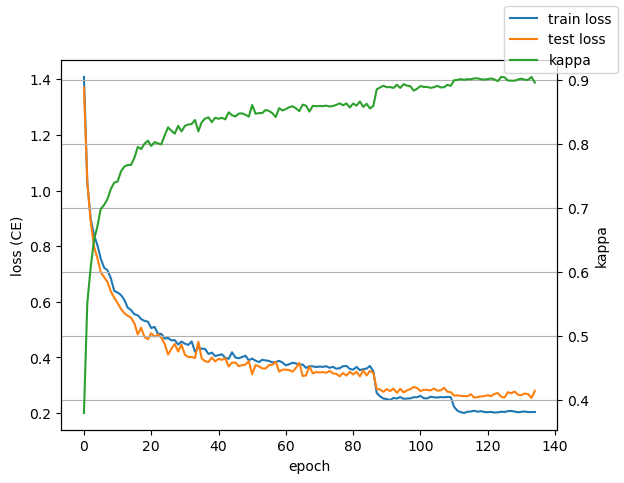

In [16]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))

In [17]:
model_save_path = "../models/cnn_v9_all.pth"
torch.save(cnn.state_dict(), model_save_path)